In [253]:
import copy
import numpy as np
import pandas as pd
import pickle

import jax
import jax.numpy as jnp

import flax
from flax import linen as nn
from flax.training import train_state

import optax


from glue_data import get_glue_data

In [597]:
import plotly.express as px
import plotly.graph_objects as go

In [383]:
[train_embeddings, eval_embeddings] = pickle.load(open('glove-wr_embeddings.p', 'br'))

In [320]:
[train_embeddings, eval_embeddings] = pickle.load(open('wr_embeddings.p', 'br'))

In [394]:
embs_train = np.sum(wr_embs, axis=-2)

In [398]:
embs_eval = np.sum(wr_embs, axis=-2)

# Train Classifier Head

In [1110]:
class Classifier(nn.Module):
    num_hidden : int   
    num_outputs : int  

    @nn.compact  
    def __call__(self, x):
        for n in self.num_hidden:
            x = nn.Dense(features=n)(x)
            x = nn.sigmoid(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

In [1111]:
def loss(params: optax.Params, batch: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    y_hat = model.apply(params, batch)

    loss_value = optax.softmax_cross_entropy_with_integer_labels(y_hat, labels).sum(axis=-1)

    return loss_value.mean()

In [1166]:
batch_size = 128

batch_idx = np.arange(batch_size*(len(embs_train) // batch_size))
batch_idx = np.reshape(batch_idx, (-1, batch_size)) 

In [1177]:
model = Classifier(num_hidden=[150, 50, 5], num_outputs=2)

In [1178]:
rng = jax.random.PRNGKey(12345)

rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (batch_size, embs_eval.shape[1]))
initial_params = model.init(init_rng, inp)

In [1180]:
for layer in initial_params['params'].keys():
initial_params['params']['Dense_0']['kernel'].shape

(768, 150)

In [1174]:
@jax.jit
def step(params, opt_state, batch, labels):
    loss_value, grads = jax.value_and_grad(loss)(params, batch, labels)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

schedule = optax.warmup_cosine_decay_schedule(
  init_value=1e-5,
  peak_value=1e-3,
  warmup_steps=500,
  decay_steps=20000,
  end_value=5e-4,
)

optimizer = optax.chain(
  optax.clip(1.0),
  optax.adamw(learning_rate=schedule),
)

optimizer = optax.adam(learning_rate=schedule)
opt_state = optimizer.init(initial_params)

params = initial_params

e_loss=[]
e_acc = []

i_epoch = 0

In [1175]:
num_epochs = 10

for epoch in range(num_epochs):
    losses = []
    for i, idx in enumerate(batch_idx):
        batch, labels = embs_train[idx], l_train[idx]
        params, opt_state, loss_value = step(params, opt_state, batch, labels)
        losses.append(loss_value)
    e_loss.append(np.mean(losses))
    e_acc.append(float(np.sum(model.apply(params, embs_eval).argmax(axis=1) == l_eval) / len(eval_embeddings['labels'])))
    print(f'epoch {i_epoch + epoch}, loss: {e_loss[-1]}, eval_acc: {e_acc[-1]:.3f}')
    
i_epoch += num_epochs

epoch 0, loss: 80.06342315673828, eval_acc: 0.720
epoch 1, loss: 58.29845428466797, eval_acc: 0.766
epoch 2, loss: 54.273441314697266, eval_acc: 0.773
epoch 3, loss: 53.33407974243164, eval_acc: 0.775
epoch 4, loss: 52.84786605834961, eval_acc: 0.781
epoch 5, loss: 52.492923736572266, eval_acc: 0.778
epoch 6, loss: 52.23831558227539, eval_acc: 0.779
epoch 7, loss: 52.0628547668457, eval_acc: 0.783
epoch 8, loss: 51.91703796386719, eval_acc: 0.784
epoch 9, loss: 51.79835891723633, eval_acc: 0.780


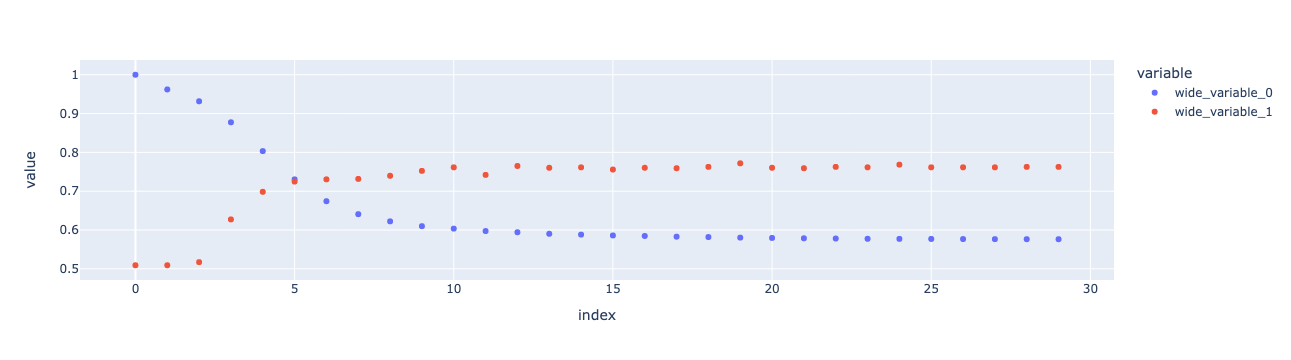

In [1143]:
px.scatter(y=[np.array(e_loss)/e_loss[0], e_acc])

# SST-2 GloVe embeddings

In [192]:
embeddings_dict = {}
with open("/Users/lara.thompson/cs224u/data/glove.840B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = ''.join(values[:-300])
        vector = np.asarray(values[-300:], "float32")
        embeddings_dict[word] = vector
        
glove_df = pd.DataFrame(embeddings_dict).transpose()
glove_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
",",-0.082752,0.672040,-0.14987,-0.064983,0.056491,0.402280,0.002775,-0.331100,-0.306910,2.0817,...,-0.14331,0.018267,-0.18643,0.207090,-0.355980,0.053380,-0.050821,-0.191800,-0.378460,-0.06589
.,0.012001,0.207510,-0.12578,-0.593250,0.125250,0.159750,0.137480,-0.331570,-0.136940,1.7893,...,0.16165,-0.066737,-0.29556,0.022612,-0.281350,0.063500,0.140190,0.138710,-0.360490,-0.03500
the,0.272040,-0.062030,-0.18840,0.023225,-0.018158,0.006719,-0.138770,0.177080,0.177090,2.5882,...,-0.42810,0.168990,0.22511,-0.285570,-0.102800,-0.018168,0.114070,0.130150,-0.183170,0.13230
and,-0.185670,0.066008,-0.25209,-0.117250,0.265130,0.064908,0.122910,-0.093979,0.024321,2.4926,...,-0.59396,-0.097729,0.20072,0.170550,-0.004736,-0.039709,0.324980,-0.023452,0.123020,0.33120
to,0.319240,0.063160,-0.27858,0.261200,0.079248,-0.214620,-0.104950,0.154950,-0.033530,2.4834,...,-0.12977,0.371300,0.18888,-0.004274,-0.106450,-0.258100,-0.044629,0.082745,0.097801,0.25045


In [195]:
raw_data, num_labels = get_glue_data('sst2')

Reusing dataset glue (/Users/lara.thompson/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [233]:
raw_data

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [929]:
sentences = raw_data['validation']['sentence']
# sentences = raw_data['train']['sentence']

In [930]:
w_embeddings = []
for sentence in sentences:
    w_freqs, w_embs = transform(sentence, word_freq, glove_df)
    n_words = len(w_embs)
    w_embs = np.array(w_embs[:64] + [np.zeros(300)]*max(0, 64-n_words))
    weights = a / (a + np.array(w_freqs[:64] + [0]*max(0, 64-n_words)))
    norm = np.linalg.norm(w_embs, axis=-1)
    mask = (norm != 0)
    norm += (~mask)
    w_embeddings.append(np.sum(w_embs * (weights * mask / norm)[:, np.newaxis], axis=0)/n_words)

In [931]:
# train_embeddings['w_embeddings'] = np.array(w_embeddings)
# train_embeddings['wr_embeddings'] = remove_component(train_embeddings['w_embeddings'], components_)
eval_embeddings['w_embeddings'] = np.array(w_embeddings)
eval_embeddings['wr_embeddings'] = remove_component(eval_embeddings['w_embeddings'], components_)

In [932]:
embs_train = train_embeddings['wr_embeddings']
embs_eval = eval_embeddings['wr_embeddings']

# Simple CC embeddings to be

In [804]:
components_, word_freq, word_embeddings = pickle.load(open('/Users/lara.thompson/repos/simple-but-tough-to-beat-examples/cc_encoder_bits.p', 'br'))

In [1189]:
word_freq["not"]

0.0009585712251401645

In [ ]:
a = 1e-3
# weights = a / (a + p_w[tokens])

In [811]:
sentences = raw_data['validation']['sentence']

In [835]:
sentences = raw_data['train']['sentence']

In [1009]:
def transform(sentence, word_freq, word_embeddings=None):
    words = sentence.split(' ')
    w_freqs = [word_freq.get(w, 0) for w in words if w != ' ']
    if word_embeddings is None:
        return w_freqs
    if type(word_embeddings) is dict:
        w_embs = [word_embeddings.get(w, np.zeros(300)) for w in words if w != ' ']
    elif type(word_embeddings) is pd.DataFrame:
        w_embs = [word_embeddings.loc[w] if ((w != ' ') and (w in word_embeddings.index)) else np.zeros(300) for w in words]
    return w_freqs, w_embs

In [1003]:
type(glove_df) is pd.DataFrame

True

In [840]:
def remove_component(w_embeddings, components_):
    return w_embeddings - np.outer(np.dot(w_embeddings, components_.T), components_)

In [836]:
w_embeddings = []
for sentence in sentences:
    w_freqs, w_embs = transform(sentence, word_freq, word_embeddings)
    n_words = len(w_embs)
    w_embs = np.array(w_embs[:64] + [np.zeros(300)]*max(0, 64-n_words))
    weights = a / (a + np.array(w_freqs[:64] + [0]*max(0, 64-n_words)))
    norm = np.linalg.norm(w_embs, axis=-1)
    mask = (norm != 0)
    norm += (~mask)
    w_embeddings.append(np.sum(w_embs * (weights * mask / norm)[:, np.newaxis], axis=0)/n_words)

In [834]:
cc_eval_embs = {'labels': raw_data['validation']['label']}
cc_eval_embs['w_embeddings'] = w_embeddings

In [837]:
cc_train_embs = {'labels': raw_data['train']['label']}
cc_train_embs['w_embeddings'] = w_embeddings

In [841]:
cc_eval_embs['wr_embeddings'] = remove_component(cc_eval_embs['w_embeddings'], components_)
cc_train_embs['wr_embeddings'] = remove_component(cc_train_embs['w_embeddings'], components_)

In [843]:
embs_train = cc_train_embs['wr_embeddings']
embs_eval = cc_eval_embs['wr_embeddings']

In [859]:
embs_train.shape

(67349, 300)

In [860]:
train_embeddings['labels'].shape

(67349,)

In [862]:
loss(initial_params, embs_train[:batch_size, :], train_embeddings['labels'][:batch_size])

Array(177.4448, dtype=float32)

# BERT embeddings

In [971]:
from transformers import AutoTokenizer

model_name_or_path = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    use_fast=True,
)

In [961]:
[train_embeddings, eval_embeddings] = pickle.load(open('embeddings.p', 'br'))

In [1006]:
train_embeddings['embeddings'].shape

(67349, 64, 768)

In [1030]:
sentences = raw_data['train']['sentence']
embeddings = train_embeddings['embeddings']

w_embeddings = []
for i, sentence in enumerate(sentences):
    words = [w for w in sentence.split(' ') if w not in [' ']][:64]
    result = tokenizer(sentence, padding="max_length", max_length=66, truncation=True)
    if len(words) == np.where(result['attention_mask'])[0][-1]-1:
        embs = embeddings[i, 1:len(words)+1, :]
    else:  # words were split, combine tokens with sum (normed later anyway)
        mask = tokenizer(words, padding="max_length", max_length=66, truncation=True)['attention_mask']  # array [num_words, 66]
        embs = np.zeros((len(words), 768))
        i_extra = 0
        for i_word, (w, m) in enumerate(zip(words, mask)):
            if m[3]==0:
                embs[i_word] = embeddings[i, i_word+i_extra, :]
            else:
                n_tokens = np.sum(m) - 2
                embs[i_word] = np.sum(embeddings[i, i_word+i_extra:i_word+i_extra+n_tokens, :], axis=0)
                i_extra = n_tokens - 1
    w_freqs = transform(sentence, word_freq)
    n_words = len(words)
    w_embs = np.concatenate([embs] + [np.zeros((1,768))]*max(0, 64-n_words))
    weights = a / (a + np.array(w_freqs + [0]*max(0, 64-n_words)))
    norm = np.linalg.norm(w_embs, axis=-1)
    mask = (norm != 0)
    norm += (~mask)
    w_embeddings.append(np.sum(w_embs * (weights * mask / norm)[:, np.newaxis], axis=0)/n_words)

In [1031]:
from sklearn.decomposition import TruncatedSVD

bert_eigen0 = TruncatedSVD(n_components=1, n_iter=7, random_state=43).fit(np.array(w_embeddings)).components_

In [1072]:
bert_train_embs['labels'] = raw_data['train']['label']
# bert_train_embs['w_embeddings'] = w_embeddings
bert_train_embs['wr_embeddings'] = remove_component(bert_train_embs['w_embeddings'], bert_eigen0)

In [1033]:
# bert_eval_embs = {'labels': raw_data['validation']['label']}
# bert_eval_embs['w_embeddings'] = w_embeddings
bert_eval_embs['wr_embeddings'] = remove_component(bert_eval_embs['w_embeddings'], bert_eigen0)

In [1073]:
embs_train = bert_train_embs['wr_embeddings']
embs_eval = bert_eval_embs['wr_embeddings']

l_train = np.array(raw_data['train']['label'])
l_eval = np.array(raw_data['validation']['label'])